In [1]:
import stim

p = 1e-3
c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,
    distance=7,
    after_clifford_depolarization=p,
    after_reset_flip_probability=p,
    before_measure_flip_probability=p,
    before_round_data_depolarization=p,
)
c = c.flattened()

In [2]:
from faulttools.glue.stim import from_stim

d, nm, measurement_nodes, observables, detectors = from_stim(c)

In [3]:
import sinter

from faulttools.glue.stim import export_to_stim_dem, wrap_dem_as_sinter_task

stim_dem = c.detector_error_model()
dem, flip_ops = export_to_stim_dem(
    nm,
    measurement_nodes=measurement_nodes,
    logicals=list(observables.values()),
    detectors=detectors,
)

In [4]:
collected_stats = sinter.collect(
    num_workers=16,
    tasks=[
        sinter.Task(circuit=c, detector_error_model=stim_dem, json_metadata={"p": 0.001, "name": "stim original"}),
        wrap_dem_as_sinter_task(dem, json_metadata={"p": 0.001, "name": "replica"}),
    ],
    max_shots=100_000_000,
    decoders=["pymatching"],
    print_progress=True,
)

Starting 16 workers...
2 tasks left:
  workers    decoder eta shots_left errors_seen json_metadata             
        8 pymatching <1m   99990511           0 p=0.001,name=stim original
        8 pymatching   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers    decoder eta shots_left errors_seen json_metadata             
        8 pymatching <1m   99780250           1 p=0.001,name=stim original
        8 pymatching   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers    decoder eta shots_left errors_seen json_metadata             
        8 pymatching <1m   99256440           7 p=0.001,name=stim original
        8 pymatching   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers    decoder eta shots_left errors_seen json_metadata             
        8 pymatching <1m   98666616           9 p=0.001,name=stim original
        8 pymatching   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  worke

Stim: 4.47e-06 error rate
NEW: 3.99e-06 error rate


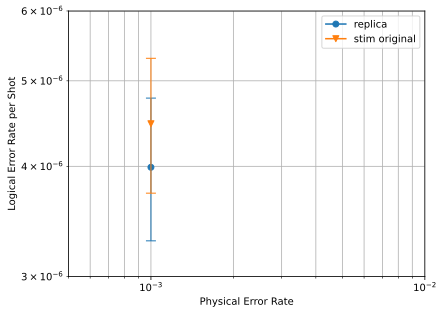

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["name"],
)
print(f"Stim: {collected_stats[0].errors / collected_stats[0].shots} error rate")
print(f"NEW: {collected_stats[1].errors / collected_stats[1].shots} error rate")
ax.set_ylim(3.00e-06, 6e-6)
ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger